In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D 
from tqdm import tqdm

In [15]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

def ignore_warn(*args, **kwargs):
    pass

In [4]:
import datetime

In [2]:
data = pd.read_pickle(r'C:\Self-Learning\Kaggle\CustomerSegmentation\online retail\features.pkl')

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,Internal
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,Yes
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Yes
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,Yes
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Yes
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Yes


### RFM Model for Customer value:
<b>RFM</b>, Recency, Frequency and Monetory Value, based model model for customer value for finding out customer segments. The RFM model will take the transaction of a customer and calculate 3 important information attributes about each customer:

*  <b>Recency</b>: The value of how recently the customer purchased at the eastablishment
*  <b>Frequency</b>: How frequent the customer's transaction are at the eastablishment
*  <b>Monetary value</b>: The monetary value of all the the transactions that customer made at the eastablishment

In [6]:
reference_date = data.InvoiceDate.max() + datetime.timedelta(days = 1)
print('Reference Date: ', reference_date)

data['days_since_last_purchase'] = (reference_date - data.InvoiceDate).astype('timedelta64[D]')
data.head()

Reference Date:  2011-12-10 12:50:00


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,Internal,days_since_last_purchase
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,Yes,374.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Yes,374.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,Yes,374.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Yes,374.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,Yes,374.0


In [7]:
# Receny
data_history_df = data[['days_since_last_purchase', 'CustomerID']].groupby('CustomerID').min().reset_index()
data_history_df.rename(columns = {'days_since_last_purchase': 'recency'}, inplace = True)

In [10]:
data_history_df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,4338.0,15300.408022,1721.808492,12346.0,13813.25,15299.5,16778.75,18287.0
recency,4338.0,92.536422,100.014169,1.0,18.00,51.0,142.00,374.0


In [18]:
from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
import seaborn as sns

def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20, 7))
    
    (mu, sigma) = norm.fit(data)
    
    #Kernel Density Plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure+' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')
    
    #QQ Plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability plot (skewness: {:.6f} and Kurtosis: {:.6f})'.format(data.skew(), data.kurt()), loc='center')
    
    
    
    plt.tight_layout()
    plt.show()
    

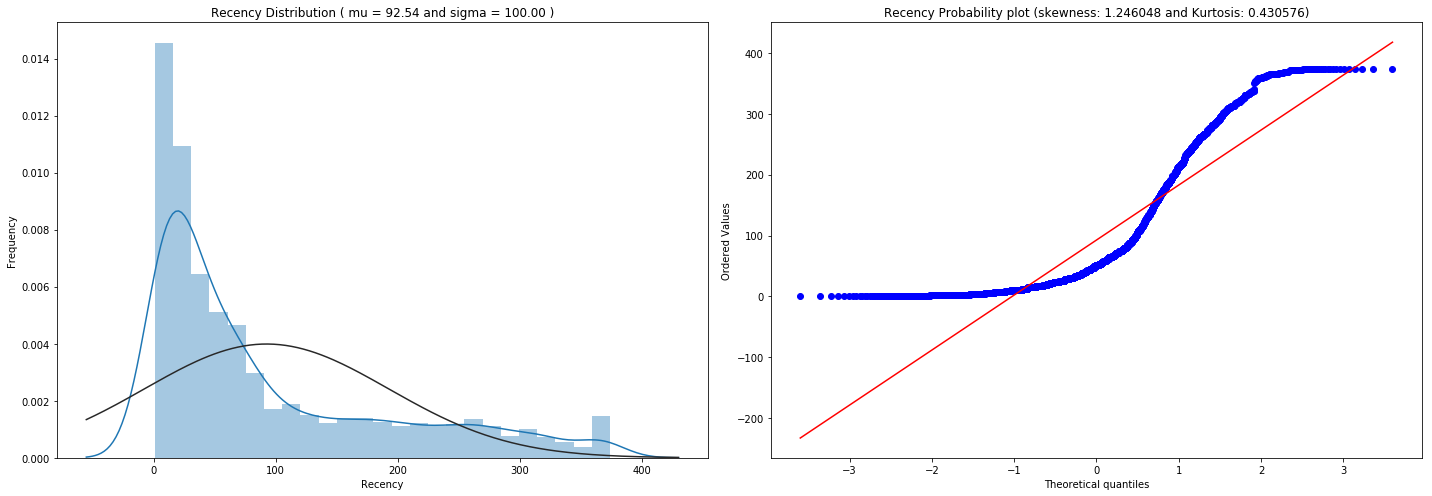

In [19]:
QQ_plot(data_history_df.recency, 'Recency')

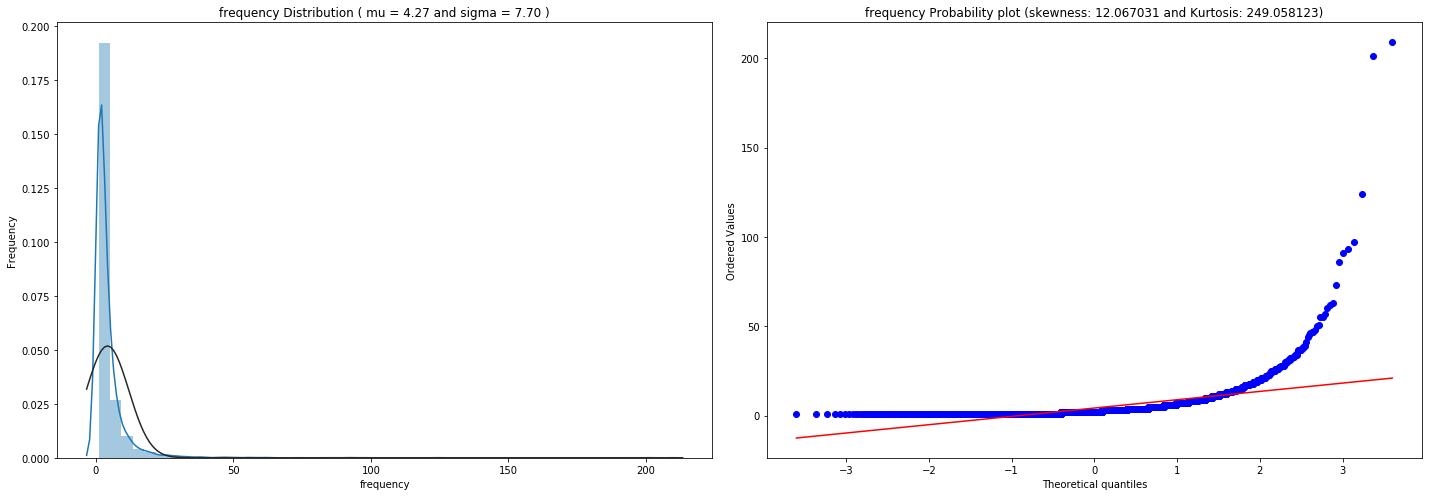

In [22]:
# Frequency
cutomer_freq = data[['CustomerID', 'InvoiceNo']].groupby(['CustomerID', 'InvoiceNo'])\
                    .count().reset_index().groupby(['CustomerID']).count().reset_index()
cutomer_freq.rename(columns = {'InvoiceNo':'frequency'}, inplace=True)
data_history_df = data_history_df.merge(cutomer_freq)
QQ_plot(data_history_df.frequency, 'frequency')

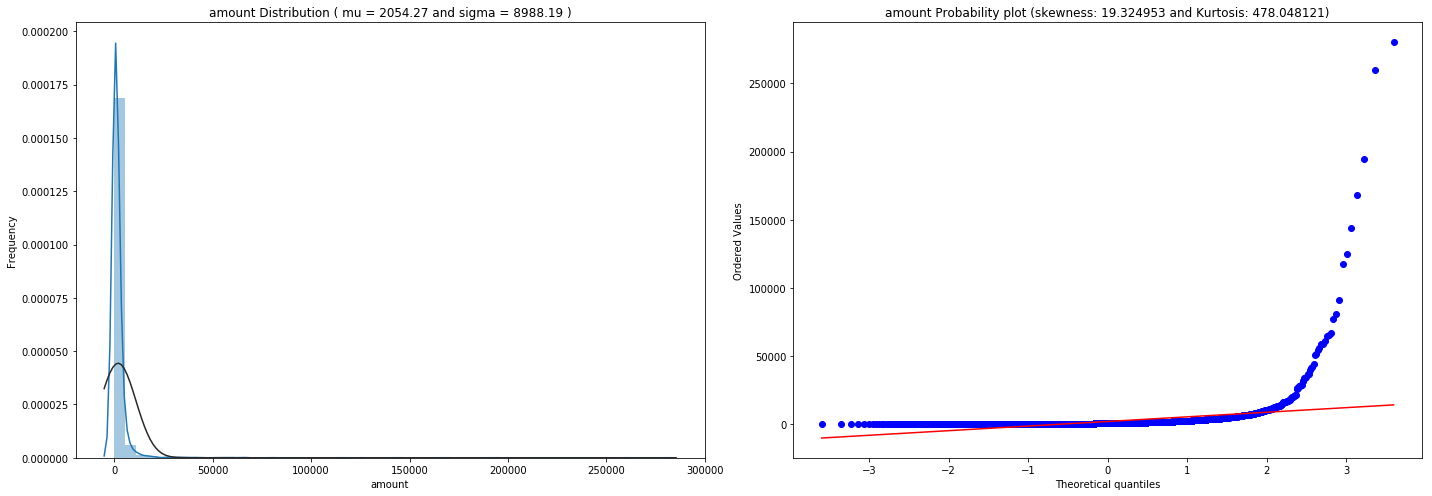

In [23]:
# Monetary value
cutomer_spend = data[['CustomerID', 'amount']].groupby(['CustomerID']).sum().reset_index()
data_history_df = data_history_df.merge(cutomer_spend)
QQ_plot(data_history_df.amount, 'amount')

In [24]:
data_history_df.describe()

,CustomerID,recency,frequency,amount
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,92.536422,4.272015,2054.266460
std,1721.808492,100.014169,7.697998,8989.230441
min,12346.000000,1.000000,1.000000,3.750000
25%,13813.250000,18.000000,1.000000,307.415000
50%,15299.500000,51.000000,2.000000,674.485000
75%,16778.750000,142.000000,5.000000,1661.740000
max,18287.000000,374.000000,209.000000,280206.020000


In [26]:
import math
from sklearn.preprocessing import StandardScaler

In [28]:
data_history_df['recency_log'] = data_history_df['recency'].apply(math.log)
data_history_df['frequency_log'] = data_history_df['frequency'].apply(math.log)
data_history_df['amount_log'] = data_history_df['amount'].apply(math.log)

feature_vector = ['recency_log', 'frequency_log', 'amount_log']

X_subset = data_history_df[feature_vector]
scaler = StandardScaler().fit(X_subset)
X_scaled = scaler.transform(X_subset)
pd.DataFrame(X_scaled, columns=X_subset.columns).describe().T

,count,mean,std,min,25%,50%,75%,max
recency_log,4338.0,-1.048288e-16,1.000115,-2.630445,-0.612424,0.114707,0.829652,1.505796
frequency_log,4338.0,-9.991495e-17,1.000115,-1.048610,-1.048610,-0.279044,0.738267,4.882714
amount_log,4338.0,-7.010426e-16,1.000115,-4.179280,-0.684183,-0.060942,0.654244,4.721395


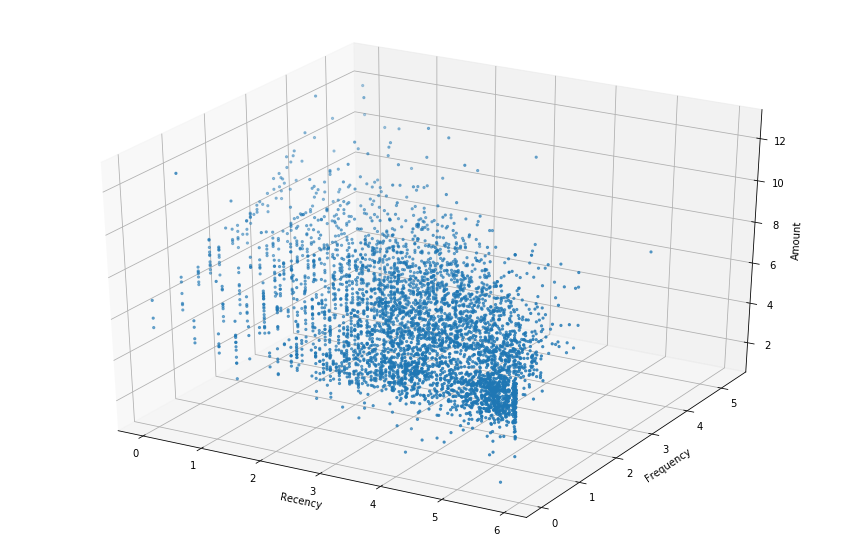

In [34]:
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection ="3d")

xs = data_history_df.recency_log
ys = data_history_df.frequency_log
zs = data_history_df.amount_log
ax.scatter3D(xs, ys, zs, s=5)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Amount')

plt.show()

The obvious patterns we can see from the plots above is that costumers who buy with a higher frequency and more recency tend to spend more based on the increasing trend in Monetary (amount value) with a corresponding increasing and decreasing trend for Frequency and Recency, respectively.

In [48]:
from sklearn.cluster import KMeans

def clustering(k_upto, data=X_scaled):
    
    cl = k_upto
    corte = 0.1
    anterior = 100000000000000
    cost = [] 
    K_best = cl
    
    for k in tqdm(range(1, cl+1)):
        model = KMeans(n_clusters=k, init='k-means++', max_iter=300, random_state=42)
        model.fit(data)
        
        # Sum of distances of samples to their closest cluster center
        interia = model.inertia_
        if (K_best == cl) and (((anterior - interia)/anterior) < corte): K_best = k - 1
        cost.append(interia)
        anterior = interia
        
    
    return K_best, cost

In [49]:
K_best, cost = clustering(50, X_scaled)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:27<00:00,  1.79it/s]


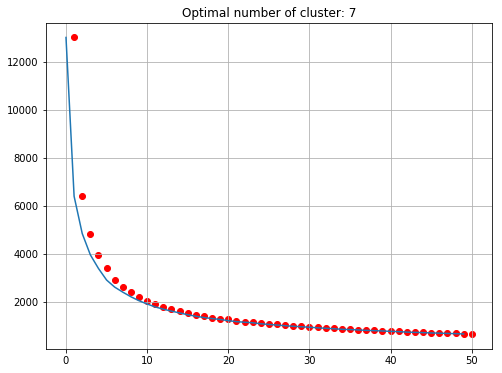

In [51]:
plt.figure(figsize=(8,6))
plt.scatter(range(1, 51), inertia, c='red')
plt.plot(inertia, linestyle='-')
plt.title('Optimal number of cluster: {}'.format(K_best))
plt.grid()
plt.show()

Through <b>Elbow Method</b>, we have evaluated optimum number of clusters to be <b>7</b> after which change in inertia is less than 10%

In [54]:
# Fit the model with the best K value

model = KMeans(n_clusters=K_best, init='k-means++', max_iter=300, random_state=42)
model.fit(X_scaled)
labels = model.labels_

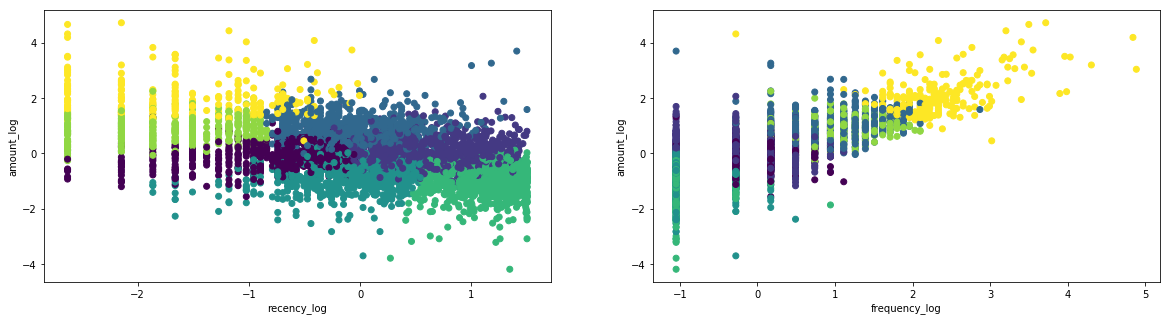

In [58]:
# Visualize Clusters

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(121)
plt.scatter(x = X_scaled[:, 0], y= X_scaled[:, 2], c=model.labels_.astype(float))
ax.set_xlabel(feature_vector[0])
ax.set_ylabel(feature_vector[2])
ax = fig.add_subplot(122)
plt.scatter(x = X_scaled[:,1], y = X_scaled[:, 2], c=model.labels_.astype(float))
ax.set_xlabel(feature_vector[1])
ax.set_ylabel(feature_vector[2])

plt.show()